# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0901s2"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1208, 32, 20, 3)
(1208, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/400
302/302 [==============================] - 3s 6ms/step - loss: 2.1818 - accuracy: 0.3087
Epoch 2/400
302/302 [==============================] - 2s 7ms/step - loss: 1.5021 - accuracy: 0.5144
Epoch 3/400
302/302 [==============================] - 2s 5ms/step - loss: 0.9852 - accuracy: 0.6960
Epoch 4/400
302/302 [==============================] - 2s 5ms/step - loss: 0.8416 - accuracy: 0.7427
Epoch 5/400
302/302 [==============================] - 2s 5ms/step - loss: 0.6406 - accuracy: 0.8064
Epoch 6/400
302/302 [==============================] - 2s 5ms/step - loss: 0.5901 - accuracy: 0.8117
Epoch 7/400
302/302 [==============================] - 2s 6ms/step - loss: 0.5010 - accuracy: 0.8400
Epoch 8/400
302/302 [==============================] - 2s 5ms/step - loss: 0.5325 - accuracy: 0.8395
Epoch 9/400
302/302 [==============================] - 2s 5ms/step - loss: 0.5080 - accuracy: 0.8366
Epoch 10/400
302/302 [==============================] - 2s 5ms/step - loss: 0.4805 - accura

302/302 [==============================] - 2s 5ms/step - loss: 0.1130 - accuracy: 0.9648
Epoch 80/400
302/302 [==============================] - 2s 6ms/step - loss: 0.0981 - accuracy: 0.9756
Epoch 81/400
302/302 [==============================] - 2s 6ms/step - loss: 0.0718 - accuracy: 0.9772
Epoch 82/400
302/302 [==============================] - 2s 6ms/step - loss: 0.0709 - accuracy: 0.9761
Epoch 83/400
302/302 [==============================] - 2s 6ms/step - loss: 0.1030 - accuracy: 0.9754
Epoch 84/400
302/302 [==============================] - 2s 6ms/step - loss: 0.0845 - accuracy: 0.9799
Epoch 85/400
302/302 [==============================] - 2s 6ms/step - loss: 0.1251 - accuracy: 0.9688
Epoch 86/400
302/302 [==============================] - 2s 6ms/step - loss: 0.0938 - accuracy: 0.9751
Epoch 87/400
302/302 [==============================] - 2s 6ms/step - loss: 0.0984 - accuracy: 0.9737
Epoch 88/400
302/302 [==============================] - 2s 6ms/step - loss: 0.1276 - accuracy: 

302/302 [==============================] - 3s 9ms/step - loss: 0.0843 - accuracy: 0.9754
Epoch 158/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0730 - accuracy: 0.9822
Epoch 159/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0624 - accuracy: 0.9904
Epoch 160/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0650 - accuracy: 0.9799: 0s - l
Epoch 161/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0751 - accuracy: 0.9773- ETA: 1s - loss: 0.0785 -  -
Epoch 162/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0439 - accuracy: 0.9864
Epoch 163/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0592 - accuracy: 0.9855
Epoch 164/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0975 - accuracy: 0.9818
Epoch 165/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0660 - accuracy: 0.9808
Epoch 166/400
302/302 [=======================

302/302 [==============================] - 3s 9ms/step - loss: 0.0392 - accuracy: 0.9867
Epoch 234/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0653 - accuracy: 0.9861
Epoch 235/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0384 - accuracy: 0.9922
Epoch 236/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0425 - accuracy: 0.9886
Epoch 237/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0407 - accuracy: 0.9907
Epoch 238/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0866 - accuracy: 0.9855
Epoch 239/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0724 - accuracy: 0.9770
Epoch 240/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0397 - accuracy: 0.9901
Epoch 241/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0284 - accuracy: 0.9860: 0s - loss: 0.0284 - accuracy: 0.98
Epoch 242/400
302/302 [==========================

302/302 [==============================] - 3s 8ms/step - loss: 0.1234 - accuracy: 0.9771
Epoch 310/400
302/302 [==============================] - 2s 8ms/step - loss: 0.0392 - accuracy: 0.9876: 1s - l - ETA: 0s -
Epoch 311/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0564 - accuracy: 0.9872
Epoch 312/400
302/302 [==============================] - 2s 8ms/step - loss: 0.0279 - accuracy: 0.9919
Epoch 313/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0369 - accuracy: 0.9895
Epoch 314/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0350 - accuracy: 0.9856
Epoch 315/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0151 - accuracy: 0.9961
Epoch 316/400
302/302 [==============================] - 3s 8ms/step - loss: 0.0265 - accuracy: 0.9931
Epoch 317/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0124 - accuracy: 0.9980
Epoch 318/400
302/302 [==============================] - 3s 9ms/st

302/302 [==============================] - 3s 9ms/step - loss: 0.0354 - accuracy: 0.9896
Epoch 387/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0255 - accuracy: 0.9909
Epoch 388/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0253 - accuracy: 0.9905
Epoch 389/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0615 - accuracy: 0.9866 0s - loss: 0.066
Epoch 390/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0182 - accuracy: 0.9938
Epoch 391/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0100 - accuracy: 0.9965ETA: 0s - loss: 0.0099 - accuracy: 0.99
Epoch 392/400
302/302 [==============================] - 3s 10ms/step - loss: 0.0331 - accuracy: 0.9906 0s - loss: 0.0332 - accuracy: 0.99
Epoch 393/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0485 - accuracy: 0.9822
Epoch 394/400
302/302 [==============================] - 3s 9ms/step - loss: 0.0267 - accuracy: 

### Learing result
 
* Visualization of the training and validation results

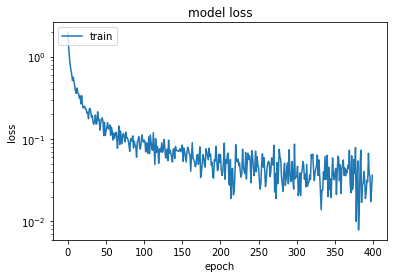

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

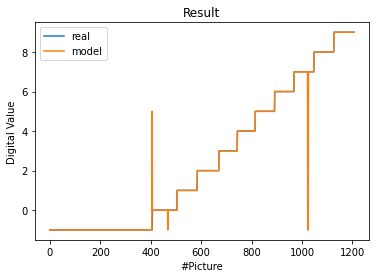

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp42ajsn3s\assets


356604

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmplvmz3msr\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmplvmz3msr\assets


98512

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/0\D6_2020-08-16_01-02-52.jpg 0 NaN
ziffer_sortiert_resize/7\D6_2020-08-19_21-15-56.jpg 7 NaN
ziffer_sortiert_resize/7\D7_2020-08-19_22-45-38.jpg 7 NaN
ziffer_sortiert_resize/NaN\Ziffer_NaN_3737.jpg NaN 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.